<a href="https://colab.research.google.com/github/shahin1009/EDMD/blob/main/EDMDc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extended Dynamic mode decomposition with Control (EDMDc)

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

plt.rcParams['figure.figsize'] = (5, 4)

In [222]:
# !pip install control

from control.matlab import *

In [223]:
# Unforced
def f(q, t):
    x, y = q
    return [y, x-x**3]


def forcing(t):
    return 2 * np.sin(2 * np.pi * 0.2 * t) * np.sin(2 * np.pi * 1 * t)

def ff(q, t):
    x, y = q
    return [y, x-x**3+forcing(t)] 

def solve(f , ic,t):
    sol = odeint(f, ic, t)
    return sol



In [224]:
t = np.linspace(0, 9.99, 1000)
dt=t[1]-t[0]
x0 = np.array([0, -2.8])
y=solve(f,x0,t)
yf = solve(ff,x0,t)
uf = forcing(t)

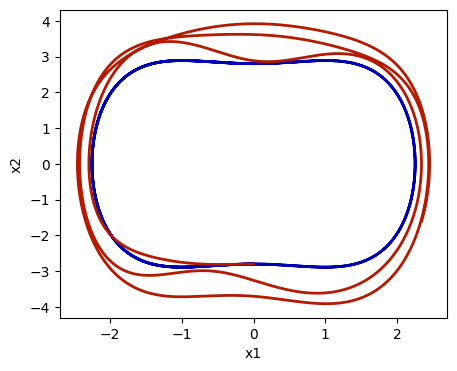

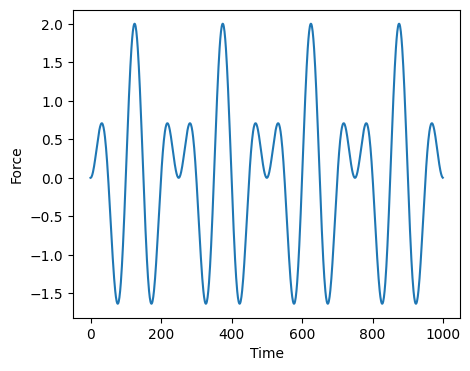

In [225]:
fig, ax1 = plt.subplots()  # Create a figure with two subplots

ax1.plot(y[:, 0], y[:, 1], '-', color=[0, 0, 0.7], linewidth=2)
ax1.plot(yf[:, 0], yf[:, 1], '-', color=[0.7, 0.1, 0], linewidth=2)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.show()

fig3 = plt.figure()
plt.plot(uf)
plt.xlabel('Time')
plt.ylabel('Force')

plt.show()

In [226]:
def buildTheta(yin, nVars, polyorder):


    """
    Builds a polynomial dictionary from input data.

    Args:
        yin: Input data.
        nVars: Number of input variables.
        polyorder: Polynomial order.

    Returns:
        Polynomial dictionary.
    """
    n = yin.shape[0]
    ind = 0
    yout = np.zeros((n, nVars))

    # Copy input variables to output
    for i in np.arange(nVars):
        yout[:, ind] = yin[:, i]
        ind += 1


    if polyorder >= 2:
        # Polynomial order 2
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                new_col = yin[:, i] * yin[:, j]
                yout = np.append(yout, new_col.reshape(-1, 1), 1)
    

    if polyorder >= 3:
        # Polynomial order 3
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    new_col = yin[:, i] * yin[:, j] * yin[:, k]
                    yout = np.append(yout, new_col.reshape(-1, 1), 1)
           
    if polyorder >= 4:
        # Polynomial order 4
        for i in np.arange(nVars):
            for j in np.arange(i, nVars):
                for k in np.arange(j, nVars):
                    for l in np.arange(k, nVars):
                        new_col = yin[:, i] * yin[:, j] * yin[:, k] * yin[:, l]
                        yout = np.append(yout, new_col.reshape(-1, 1), 1)
             


    return yout

In [227]:
polyorder = 4
nvar = 2

Theta = buildTheta(yf, nvar, polyorder)

Nstates = Theta.shape[1]
G = np.append(Theta[:-1,:], uf[:-1].reshape(-1, 1), 1)


In [228]:
print(G.shape)
print(Theta.shape)

(999, 15)
(1000, 14)


In [229]:
from scipy.linalg import svd , inv

Ug, Sg, Vg = svd(G, full_matrices=False)
# SVD
AB = Theta[1:,:].T @ Ug @ inv(np.diag(Sg[:15])) @ Vg

# or
# AB = Vg.T @ inv(np.diag(Sg[:15])) @ Ug.T @ Theta[1:,:]
# AB = AB.T


Am = AB[:Nstates, :Nstates]
Bm = np.array(AB[:,-1]).reshape(-1,1)
Cm = np.eye(Nstates) 
Dm = np.zeros((Nstates, 1))


In [230]:
Bm.shape

(14, 1)

In [231]:
sysmodel_EDMDc = ss(Am,Bm,Cm,Dm,t[1]-t[0])

In [232]:
yEDMDc, T, xout = lsim(sysmodel_EDMDc,uf,t,buildTheta(x0.reshape(1,-1),nvar, polyorder).T)

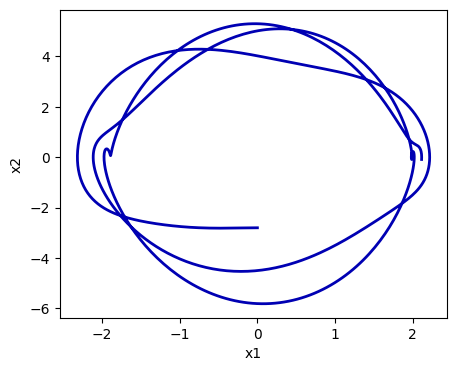

In [233]:
fig, ax1 = plt.subplots()  # Create a figure with two subplots

ax1.plot(yEDMDc[:, 0], yEDMDc[:, 1], '-', color=[0, 0, 0.7], linewidth=2)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
plt.show()